In [ ]:
pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185322 sha256=634aa65e07cf24725d31ced2c50a62200f421cce2d359823fe1c4f77748a570c
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI

In [ ]:
vp = np.load('/content/Marmousi_cropped.npy')

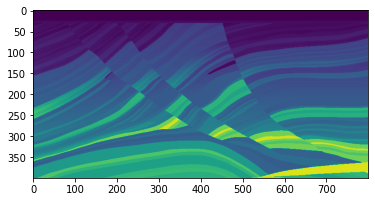

In [ ]:
plt.imshow(vp)

In [ ]:
%%writefile sequential_solution.py
import numpy as np
np.load('/content/Marmousi_cropped.npy')
nz = 800 # number of grid points in the horizontal direction
nx = 400 # number of grid points in the vertical direction
dd = 5.0 # grid cell size
nt = 5000 # number of time samples to be modeled
dt = 0.0005 # time step
srcx = 900 # source horizontal location in meters
srcz = 800 # source vertical location in meters

nabs = 40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)

# vp = np.arange(2000,4500,(4500-2000)/nz)
# vp = np.tile(np.expand_dims(vp,0),[nx,1]) # just coming up with a velocity model

#vp = np.ones((nx,nz))*3000.0

time = np.arange(0,nt*dt,dt) # time vector
f0 = 15. # central frequency of the wavelet
t0 = 1/f0 # a shift to make sure wavelet is causal
wav  = (1.0-2.0*np.power(np.pi*f0*(time-t0),2))*np.exp(-np.power(np.pi*f0*(time-t0),2)) # computing the wavelet
def gen_absorb(nx,nz,nabs,a,FreeSurf=False):
    absorb = np.ones((nx,nz))
    abs_coefs = np.zeros(nabs)
    abs_coefs = np.exp(-(a**2 * (nabs-np.arange(nabs))**2))
    absorb[:nabs,:] = absorb[:nabs,:]*np.expand_dims(abs_coefs,1)
    absorb[-nabs:,:] = absorb[-nabs:,:]*np.expand_dims(abs_coefs[::-1],1)
    absorb[:,-nabs:] = absorb[:,-nabs:]*abs_coefs[::-1]
    if(FreeSurf==False):
        absorb[:,:nabs] = absorb[:,:nabs]*abs_coefs
    return absorb
def comp_deriv(p,dd):
    pdx2 = np.zeros(p.shape)
    pdz2 = np.zeros(p.shape)

    pdx2[1:-1,1:-1] = (p[2:,1:-1]-2*p[1:-1,1:-1]+p[:-2,1:-1])/(dd**2)
    pdz2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1,1:-1]+p[1:-1,:-2])/(dd**2)
    return pdx2, pdz2
def fd_ac(vp,dd,dt,srcx,srcz,wav,nabs=40,a=0.0053,FreeSurf=False):
    srci = int(srcx/dd) # find where source is located on the grid
    srcj = int(srcz/dd)
    nx,nz = vp.shape # infer shapes
    nt = wav.shape[0]

    field2d = np.zeros((nx,nz,nt),dtype=np.float32) # define variables  - field2d is output wavefield
    p = np.zeros((nx,nz),dtype=np.float32) # these are pressures at current, prev and next steps
    ppast = np.zeros((nx,nz),dtype=np.float32)
    pfut = np.zeros((nx,nz),dtype=np.float32)
    
    vp2 = vp**2 # square of velocity for easier computation
    absorb = gen_absorb(nx,nz,nabs,a,FreeSurf=FreeSurf) # generate absorbing mask
    
    for i in range(nt): # main loop
        pdx2, pdz2 = comp_deriv(p,dd) # compute pressure derivatives
        pfut = 2 * p + vp2 * dt**2 * (pdx2 + pdz2) - ppast # compute future pressure from current and prev 
        pfut[srci,srcj] = pfut[srci,srcj] + wav[i] / (dd * dd) * dt ** 2 # inject source term at selected point
        
        p *= absorb # apply absorbing mask
        pfut *= absorb # apply absorbing mask

        field2d[:,:,i] = p  # save current pressure in output array

        ppast = p # redefine arrays moving to next step
        p = pfut
    return field2d
wvfld = fd_ac(vp,dd,dt,srcx,srcz,wav,nabs,a,FreeSurf) # example computation

Writing sequential_solution.py


In [ ]:
%timeit -n 1 -r 1 -o !python sequential_solution.py

In [ ]:
%%writefile mpi_solution.py
from mpi4py import MPI
import numpy as np
comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

nz = 800 # number of grid points in the horizontal direction
nx = 400 # number of grid points in the vertical direction
dd = 5.0 # grid cell size
nt = 5000 # number of time samples to be modeled
dt = 0.0005 # time step
srcx = 900 # source horizontal location in meters
srcz = 800 # source vertical location in meters
nabs = 40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)
time = np.arange(0,nt*dt,dt) # time vector
f0 = 15. # central frequency of the wavelet
t0 = 1/f0 # a shift to make sure wavelet is causal
if rank==0:
    vp = np.load('/content/Marmousi_cropped.npy')
    wav  = (1.0-2.0*np.power(np.pi*f0*(time-t0),2))*np.exp(-np.power(np.pi*f0*(time-t0),2)) # computing the wavelet
else:
    wav,vp = None, None
wav,vp = comm.bcast([wav,vp],root=0)

def gen_absorb(nx,nz,nabs,a,FreeSurf=False):
    absorb = np.ones((nx,nz))
    abs_coefs = np.zeros(nabs)
    abs_coefs = np.exp(-(a**2 * (nabs-np.arange(nabs))**2))
    absorb[:nabs,:] = absorb[:nabs,:]*np.expand_dims(abs_coefs,1)
    absorb[-nabs:,:] = absorb[-nabs:,:]*np.expand_dims(abs_coefs[::-1],1)
    absorb[:,-nabs:] = absorb[:,-nabs:]*abs_coefs[::-1]
    if(FreeSurf==False):
        absorb[:,:nabs] = absorb[:,:nabs]*abs_coefs
    return absorb
def comp_deriv(p,dd, domain, P):
    pdx2 = np.zeros(p.shape)
    pdz2 = np.zeros(p.shape)
    #nodes calculation
    if rank==0:
        add = domain[-1]+1
        pdx2[1:-1,1:] = (P[2:,1:add]-2*P[1:-1,1:add]+P[:-2,1:add])/(dd**2)
        pdz2[1:-1,1:] = (P[1:-1,2:add+1]-2*P[1:-1,1:add]+P[1:-1,:add-1])/(dd**2)

        # pdx2[1:, 1:-1] = (P[1:add, 2:]-2*P[1:add, 1:-1]+P[1:add,:-2])/(dd**2)
        # pdz2[1:, 1:-1] = (P[2:add+1,1:-1]-2*P[1:add,1:-1]+P[:add-1,1:-1])/(dd**2)
        
        
    elif rank == size-1:
        add = domain[0]-1
        pdx2[1:-1,:-1] = (P[2:,add:-2]-2*P[1:-1,add:-2]+P[:-2,add:-2])/(dd**2)
        pdz2[1:-1,:-1] = (P[1:-1,add-1:-3]-2*P[1:-1,add:-2]+P[1:-1,add+1:-1])/(dd**2)

        # pdx2[:-1, 1:-1] = (P[add:, 2:]-2*P[add:, 1:-1]+P[add:, :-2])/(dd**2)
        # pdz2[:-1, 1:-1] = (P[add-1:, 1:-1]-2*P[add:, 1:-1]+P[add+1:, 1:-1])/(dd**2)
        
        
    else:
        start = domain[0]-1
        end = domain[-1]+1
        pdx2[1:-1,:] = (P[2:,start+1:end]-2*P[1:-1,start+1:end]+P[:-2,start+1:end])/(dd**2)
        pdz2[1:-1,:] = (P[1:-1,start:end-1]-2*P[1:-1,start+1:end]+P[1:-1,start+2:end+1])/(dd**2)
        
        # pdx2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1, 1:-1]+p[1:-1, :-2])/(dd**2)
        # pdz2[1:-1,1:-1] = (p[2:, 1:-1]-2*p[1:-1,1:-1]+p[:-2, 1:-1])/(dd**2)
       
    
    return pdx2, pdz2
if rank == 0:
    nx,nz = vp.shape # infer shapes
    nn = nz//size
    array = np.arange(nz)
    nodes = np.split(array, array[nn:nn*size:nn])
    srci = int(srcx/dd) # find where source is located on the grid
    srcj = int(srcz/dd)
    rang = srci//nn
    srci = srci-nodes[rang][0]
    nt = wav.shape[0]
    field2d = np.zeros((nx,nz,nt),dtype=np.float32) # define variables  - field2d is output wavefield
    vp2 = vp**2 # square of velocity for easier computation
    Ppast = np.zeros((nx,nz),dtype=np.float32)
    Pfut = np.zeros((nx,nz),dtype=np.float32)
    P = np.zeros((nx,nz),dtype=np.float32)
else:
    srci, srcj, nx, nz, nt, vp2, nodes, rang, Ppast, Pfut, P = None, None, None, None, None, None, None, None, None, None, None 
Ppast, Pfut, P, nx, nz, nt, vp2, nodes, rang = comm.bcast([Ppast, Pfut, P, nx, nz, nt, vp2, nodes, rang], root=0)
srci, srcj = comm.send(srci, dest=rang), comm.send(srcj, dest=rang)
#Mark up subdomains
domain = nodes[rank]
p = np.zeros((nx,len(domain)),dtype=np.float32) # these are pressures at current, prev and next steps
pfut = np.zeros((nx,len(domain)),dtype=np.float32)
ppast = np.zeros((nx,len(domain)),dtype=np.float32)
absorb = gen_absorb(nx,nz,nabs,a,FreeSurf=FreeSurf) # generate absorbing mask
for i in range(nt): # main loop
    pdx2, pdz2 = comp_deriv(p,dd, domain, P) # compute pressure derivatives
    # print(np.array(nodes))
    pfut = 2 * p + vp2[:, domain] * dt**2 * (pdx2 + pdz2) - ppast # compute future pressure from current and prev 
    if rank == rang:
        pfut[srci,srcj] = pfut[srci,srcj] + wav[i] / (dd * dd) * dt ** 2 # inject source term at selected point
    Pfut = comm.gather(pfut, root=0)
    if rank == 0:
        Pfut = np.concatenate(P).reshape(nx, nz)
        P *= absorb # apply absorbing mask
        Pfut *= absorb # apply absorbing mask

        field2d[:,:,i] = P  # save current pressure in output array

        Ppast = P# redefine arrays moving to next step
        P = Pfut
    P = comm.bcast(P, root=0)

Overwriting mpi_solution.py


In [ ]:
# %timeit -n 1 -r 1 -o !mpiexec /np 3 python mpi_solution.py
!mpirun --allow-run-as-root -n 3 python mpi_solution.py
